# bios8366_fp_pw_110918.ipynb

# 11.09.18

In [2]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pylab as plt
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

# Set seed
np.random.seed(10011)

/anaconda2/envs/bios8366/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda2/envs/bios8366/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


paper on using lab results (23) for calculating readmission risk:  

"It included weighted age, sex, and a total of 23 numeric laboratory test results: (a) serum chemistry: albumin, aspartate transaminase, alkaline phosphatase, blood urea nitrogen, calcium, creatinine, glucose, potassium, sodium, and total bilirubin; (b) hematology and coagulation parameters: bands, hemoglobin, partial thromboplastin time, prothrombin time international normalized ratio, platelets, and white blood cell count; (c) arterial blood gas: partial pressure of carbon dioxide, partial pressure of oxygen, and pH value; (d) cardiac markers: brain natriuretic peptide, creatine phosphokinase MB, probrain natriuretic peptide, and troponin I.".  

PMID = 27755391

1) Analysis of lab data 

In [6]:
df_LAB = pd.read_csv('./Data/FONNESBECK_LAB_20151202.csv',sep=',',engine='python',quoting=3)
df_LAB.head()

,RUID,Lab_name,Lab_date,Lab_value
0,50135262,%SAT,04/13/2008,17
1,50135262,ABO,02/08/2007,A
2,50135262,ABO,02/24/2008,a
3,50135262,AN-GAP,02/08/2007,9
4,50135262,AN-GAP,02/11/2011,8


In [8]:
df_LAB1 = df_LAB.copy()

In [9]:
df_LAB1.isnull().sum(0)

RUID             0
Lab_name         4
Lab_date         0
Lab_value    13489
dtype: int64

In [10]:
df_LAB1.shape

(9162715, 4)

In [11]:
# rows with missing lab values
df_LAB_missing1 = df_LAB1[df_LAB1['Lab_value'].isnull()]
df_LAB_missing1.head()

,RUID,Lab_name,Lab_date,Lab_value
22721,50135425,TSTCLL,02/12/2014,NaN
41728,50135759,Dt,09/20/2013,NaN
41730,50135759,Du,09/20/2013,NaN
41731,50135759,Dv,09/06/2013,NaN
41732,50135759,Dw,09/20/2013,NaN


In [34]:
# count number of unique patients in lab dataset
df_LAB['RUID'].nunique()

7799

In [35]:
# count number of unique patients with at least one missing value 
df_LAB_missing1['RUID'].nunique()

789

there are 7,799 unique patients in the lab data set with 789 with at least one missing lab value

In [27]:
df_LAB_missing2 = pd.DataFrame(df_LAB_missing1[['Lab_name']].groupby(['Lab_name']).size()).reset_index()

In [32]:
pd.set_option('display.max_rows', 500)
df_LAB_missing2.columns=['Lab_name','count']
df_LAB_missing2.sort_values(by='count',ascending=False)

,Lab_name,count
52,Ee,952
56,El,755
53,Eg,734
60,Er,688
96,T3,612
49,Eb,594
57,Em,592
45,Dw,592
107,U8,592
59,Eq,589


In [50]:
df_LAB_missing2[df_LAB_missing2['count']>0].shape

(122, 2)

there are 122 unique labs with at least 1 missing value

In [41]:
# count number of unique labs with at least one missing value
df_LAB2 = pd.DataFrame(df_LAB1[['Lab_name']].groupby(['Lab_name']).size()).reset_index()

In [44]:
pd.set_option('display.max_rows', 100)
df_LAB2.columns = ['Lab_name','counts']
df_LAB2.sort_values(by='counts',ascending=False)

,Lab_name,counts
1762,GluBed,252113
2218,K,238492
1154,Creat,233493
2609,Na,230471
2776,PCV,229964
592,BUN,226556
1765,Gluc,226554
926,CO2,226256
1070,Cl,226059
2920,Plt-Ct,215131


In [98]:
df_LAB2.sort_values(by='counts',ascending=False).head(100)

,Lab_name,counts
1762,GluBed,252113
2218,K,238492
1154,Creat,233493
2609,Na,230471
2776,PCV,229964
592,BUN,226556
1765,Gluc,226554
926,CO2,226256
1070,Cl,226059
2920,Plt-Ct,215131


In [46]:
# how many labs are in at least 1% of our cohort, i.e. 77 counts?
df_LAB2[df_LAB2['counts']>76].shape

(1152, 2)

there are 1,152 that are in at least 1% of our cohort

In [47]:
# how many labs are in at least 5% of our cohort, i.e. 389 counts?
df_LAB2[df_LAB2['counts']>388].shape

(634, 2)

there are 634 that are in at least 1% of our cohort

In [37]:
df_LAB_missing2[df_LAB_missing2['count']>69].shape

(30, 2)

there are 30 unique labs with at least 70 missing values

Among the 30 unique labs, ones that I recognize:  
* T3 = thyroid lab
* GramSt = Gram Stain
* LDL-C = LDL cholesterol

In [40]:
# how many unique labs are there?
df_LAB1[['Lab_name']].nunique()

Lab_name    4061
dtype: int64

there are 4,061 unique labs in this dataset

In [ ]:
# get counts of unique lab values
df_LAB1[['Lab_name']].nunique()

-current status:  
* can discuss whether we believe that the missing labs are important for predicting readmission  
* a possible idea is to use the literature to select the labs that we think are important (i.e. via knowledge domain) and clean up these labs

To do:  
* can look at whether there is a certain years by which lab values are missing 

2) analysis of BP

In [51]:
df_BP = pd.read_csv('./Data/FONNESBECK_BP_20151202.csv',sep=',')
df_BP.head()

,RUID,SYSTOLIC,DIASTOLIC,Measure_date
0,50135262,150,80,01/09/2005
1,50135262,137,77,02/08/2007
2,50135262,137,78,02/08/2007
3,50135262,190,78,02/08/2007
4,50135262,190,77,02/08/2007


In [52]:
# look at data missingness
df_BP1 = df_BP.copy()
df_BP1.isnull().sum(0)

RUID            0
SYSTOLIC        0
DIASTOLIC       0
Measure_date    0
dtype: int64

no missing values

In [54]:
# summary stats
df_BP1.describe()

,RUID,SYSTOLIC,DIASTOLIC
count,1.043040e+07,1.043040e+07,1.043040e+07
mean,5.366709e+07,1.189580e+02,6.523043e+01
std,4.701959e+05,2.702595e+01,1.764321e+01
min,5.013526e+07,0.000000e+00,0.000000e+00
25%,5.372991e+07,1.020000e+02,5.400000e+01
50%,5.373206e+07,1.170000e+02,6.400000e+01
75%,5.373438e+07,1.340000e+02,7.500000e+01
max,5.373642e+07,9.970000e+02,9.760000e+02


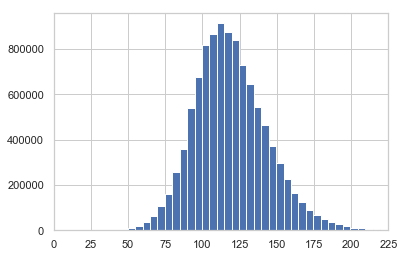

In [63]:
# systolic histogram
plt.xlim(right=225)
_=plt.hist(df_BP1.SYSTOLIC,bins=200)

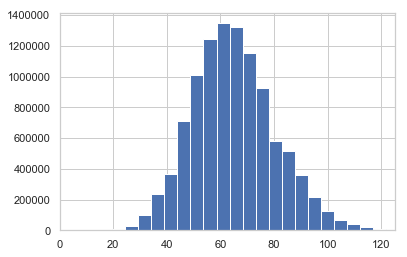

In [65]:
# diastolic histogram
plt.xlim(right=125)
_=plt.hist(df_BP1.DIASTOLIC,bins=200)

3) analyze BMI

In [66]:
df_BMI = pd.read_csv('./Data/FONNESBECK_BMI_20151202.csv',sep=',')
df_BMI.head()

,RUID,BMI,Date_BMI,BMI_Weight,BMI_Height,Pregnancy_Indicator
0,50135262,41.43,01/09/2005,119.98,170.18,0
1,50135262,22.86,02/11/2011,70.00,175.00,0
2,50135262,43.07,02/12/2011,131.90,175.00,0
3,50135262,43.06,02/12/2011,131.86,175.00,0
4,50135262,41.47,02/12/2011,127.00,175.00,0


In [67]:
# look at data missingness
df_BMI1 = df_BMI.copy()
df_BMI1.isnull().sum(0)

RUID                     0
BMI                    307
Date_BMI                 0
BMI_Weight             307
BMI_Height               0
Pregnancy_Indicator      0
dtype: int64

307 with missing values

In [68]:
# summary stats
df_BMI1.describe()

,RUID,BMI,BMI_Weight,BMI_Height,Pregnancy_Indicator
count,2.629060e+05,262599.000000,262599.000000,262906.000000,262906.000000
mean,5.366223e+07,39.116793,68.429544,148.394647,0.036869
std,4.851191e+05,589.110234,175.278235,162.113102,0.188440
min,5.013526e+07,-31.160000,-95.710000,5.000000,0.000000
25%,5.372982e+07,19.080000,41.920000,144.780000,0.000000
50%,5.373197e+07,25.240000,71.300000,163.830000,0.000000
75%,5.373439e+07,31.570000,91.200000,175.260000,0.000000
max,5.373642e+07,97600.000000,74075.000000,23540.970000,1.000000


In [80]:
# drop NaN values
df_BMI2 = df_BMI1.dropna()

In [81]:
df_BMI2.head()

,RUID,BMI,Date_BMI,BMI_Weight,BMI_Height,Pregnancy_Indicator
0,50135262,41.43,01/09/2005,119.98,170.18,0
1,50135262,22.86,02/11/2011,70.00,175.00,0
2,50135262,43.07,02/12/2011,131.90,175.00,0
3,50135262,43.06,02/12/2011,131.86,175.00,0
4,50135262,41.47,02/12/2011,127.00,175.00,0


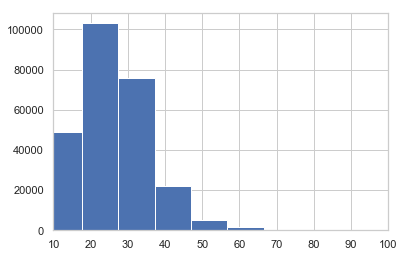

In [85]:
# BMI histogram
plt.xlim(left=10)
plt.xlim(right=100)
_=plt.hist(df_BMI2['BMI'],bins=10000)

In [86]:
# get summary stats after setting limits

In [90]:
df_BMI3 = df_BMI2[(df_BMI2.BMI > 9) & (df_BMI2.BMI < 100)]
df_BMI3.describe()

,RUID,BMI,BMI_Weight,BMI_Height,Pregnancy_Indicator
count,2.552960e+05,255296.000000,255296.000000,255296.000000,255296.000000
mean,5.366046e+07,26.359588,67.874472,149.052472,0.037701
std,4.911380e+05,9.409710,37.511140,41.712184,0.190473
min,5.013526e+07,9.010000,0.850000,19.500000,0.000000
25%,5.372982e+07,19.570000,46.900000,149.860000,0.000000
50%,5.373200e+07,25.450000,72.170000,165.100000,0.000000
75%,5.373439e+07,31.640000,91.740000,175.260000,0.000000
max,5.373642e+07,99.500000,360.000000,304.800000,1.000000


-status:
* could impute BMI from last or next visit for same patient, or from patient most like patient based on some features

4) analyze EGFR

In [92]:
df_EGFR = pd.read_csv('./Data/FONNESBECK_EGFR_20151202.csv',sep=',')
df_EGFR.head()

,RUID,EGFR,egfr_date
0,50135262,123.68000,02/08/2007
1,50135262,123.67783,02/08/2007
2,50135262,76.40173,02/11/2011
3,50135262,76.40000,02/11/2011
4,50135262,78.64000,02/12/2011


In [93]:
# look at data missingness
df_EGFR1 = df_EGFR.copy()
df_EGFR1.isnull().sum(0)

RUID         0
EGFR         0
egfr_date    0
dtype: int64

no missing EGFR values

In [94]:
# summary stats
df_EGFR1['EGFR'].describe()

count    323614.000000
mean        116.178002
std         153.138220
min           0.000000
25%          48.523045
50%          81.370000
75%         123.190730
max        3213.780000
Name: EGFR, dtype: float64

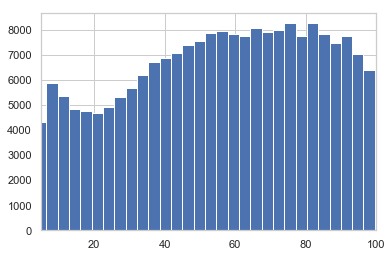

In [97]:
# BMI histogram
plt.xlim(left=5)
plt.xlim(right=100)
_=plt.hist(df_EGFR1['EGFR'],bins=1000)

bars